In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
# 데이터 로드
tr = pd.read_csv('data/train0726.csv')
te = pd.read_csv('data/test0723.fi.csv')

In [3]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   code              423 non-null    object 
 1   tot_pop           423 non-null    int64  
 2   region            423 non-null    int64  
 3   num_empty         423 non-null    int64  
 4   sub               423 non-null    int64  
 5   bus               423 non-null    int64  
 6   num_park          423 non-null    int64  
 7   type_new          423 non-null    int64  
 8   prop_type_im1     423 non-null    float64
 9   prop_type_im2     423 non-null    float64
 10  prop_type_im3     423 non-null    float64
 11  prop_type_im4     423 non-null    int64  
 12  prop_type_im5     423 non-null    float64
 13  prop_type_im6     423 non-null    float64
 14  prop_type_im7     423 non-null    float64
 15  prop_type_im8     423 non-null    float64
 16  prop_type_im9     423 non-null    float64
 1

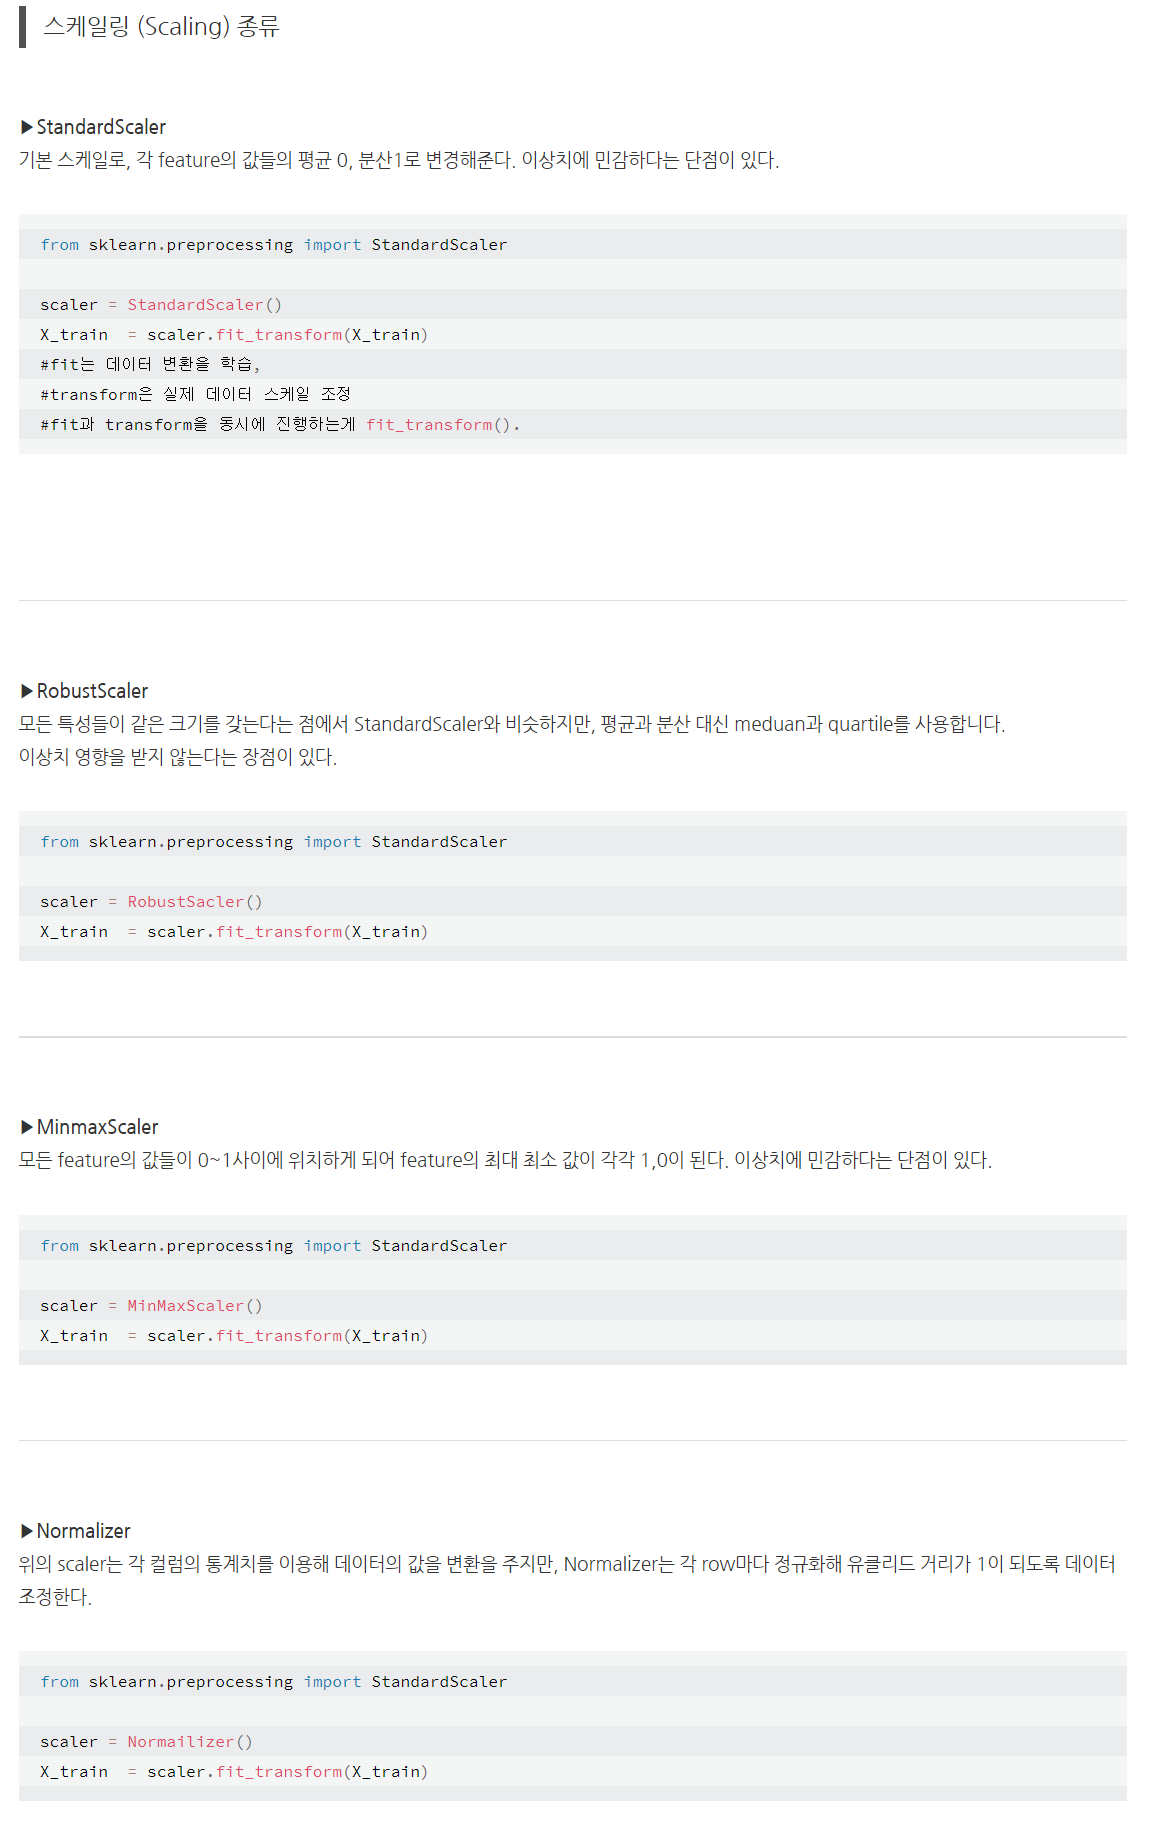

### 4.2 Randomforest


In [4]:
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [5]:
train = tr.set_index("code")
test = te.set_index("code")
# train["지역"] = train["지역"].astype('category').cat.codes
# test["지역"] = test["지역"].astype('category').cat.codes


In [6]:
train.head()

,tot_pop,region,num_empty,sub,bus,num_park,type_new,prop_type_im1,prop_type_im2,prop_type_im3,...,prop_areaL21,prop_areaL29,prop_areaL36,prop_areaL39,prop_areaL46,prop_areaL59,prop_areaU59,M_fee_deposit,M_fee_rent,target
code,,,,,,,,,,,,,,,,,,,,,
C1000,566,16,10,0,1,438,0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.428571,0.285714,0.285714,0.000000,14404000.0,129640,481
C1004,521,15,3,0,2,153,1,0.0,0.0,0.0,...,0.526316,0.052632,0.157895,0.157895,0.000000,0.052632,0.052632,19000000.0,119860,93
C1004,521,15,3,0,2,153,1,0.0,0.0,0.0,...,0.526316,0.052632,0.157895,0.157895,0.000000,0.052632,0.052632,19000000.0,119860,93
C1005,1144,15,16,0,8,950,0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,16348000.0,210900,376
C1013,1308,5,16,0,6,1119,0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.200000,0.600000,0.200000,0.000000,24665000.0,135960,1665


In [7]:
test.head()

,tot_pop,region,num_empty,sub,bus,num_park,type_new,prop_type_im2,prop_type_im3,prop_type_im5,...,prop_type_qual11,prop_type_qual12,prop_type_qual13,prop_type_qual14,M_fee_deposit,M_fee_rent,prop_type_im1,prop_type_qual6,prop_type_im4,prop_type_im9
code,,,,,,,,,,,,,,,,,,,,,
C1072,754,2,14,0,2,683,0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,39772500.0,273355,0,0,0,0
C1128,1354,2,9,0,3,1216,0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,36048000.0,249930,0,0,0,0
C1456,619,8,18,0,16,547,0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,36048000.0,234300,0,0,0,0
C1840,593,13,7,0,3,543,0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,18023000.0,120145,0,0,0,0
C1332,1297,2,11,0,2,1112,0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,42776000.0,302800,0,0,0,0


In [8]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [9]:
scailing_features = ['tot_pop',
                     'num_park',
                     'region',
                     'sub',
                     'bus',
                     'num_empty',
                     'M_fee_deposit',
                     'M_fee_rent',
                    ]

scaler = RobustScaler()
train.loc[:, scailing_features] = scaler.fit_transform(train[scailing_features])
test.loc[:, scailing_features] = scaler.transform(test[scailing_features])

# Modeling with Gradient Boosting Regressor

- Setting Data For Model

In [10]:
X = train.drop(columns = ['target'])
y = train['target']

- Hyper params Tuning

In [11]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [12]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-29 16:28:46,712] A new study created in memory with name: cat_opt
[I 2021-07-29 16:28:47,116] Trial 0 finished with value: 115.01484344354215 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 115.01484344354215.
[I 2021-07-29 16:28:47,271] Trial 1 finished with value: 117.42149151040381 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 0 with value: 115.01484344354215.
[I 2021-07-29 16:28:47,391] Trial 2 finished with value: 159.01271356352652 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 0 with value: 115.01484344354215.
[I 2021-07-29 16:28:47,540] Trial 3 finished with value: 109.93589298484974 and parameters: {'max_depth'

Best Score: 109.66088486738607
Best trial: {'max_depth': 10, 'colsample_bylevel': 0.8341048247374584, 'subsample': 0.3455361150896956, 'min_child_samples': 96, 'max_bin': 490}


In [13]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

- StratifiedK-Fold for Regression

In [14]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(5)

preds = []
for tr_id, val_id in skf.split(X, y_cat) : 
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    
    pred = cat.predict(test)
    preds.append(pred)
cat_pred = np.mean(preds, axis = 0)

In [15]:
sample = pd.read_csv('data/sample_submission.csv')
sample['num'] = cat_pred
sample.to_csv('sub/cat0729_4.csv', index=False)

In [16]:
sample

,code,num
0,C1072,728.853212
1,C1128,1212.866760
2,C1456,542.478503
3,C1840,535.158393
4,C1332,1102.962121
...,...,...
145,C2456,256.990433
146,C1266,465.891073
147,C2152,247.755683
148,C1267,407.965103


In [17]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

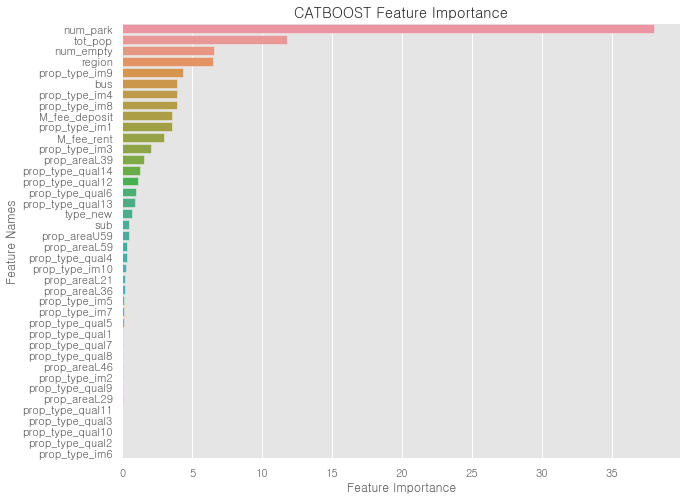

In [18]:
plot_feature_importance(cat.get_feature_importance(),test.columns,'CATBOOST')

In [19]:
temp = pd.read_csv('data/train.csv')

In [20]:
temp.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
